In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import numpy as np
from collections import defaultdict
from itertools import islice
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics import Accuracy, Precision, Recall
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split


# Loading the data

In [2]:
cloths_train_data = datasets.FashionMNIST(root= "Ecommerce_clothing_classifier", 
                                          train= True, transform= transforms.ToTensor(), download= True)

cloths_test_data = datasets.FashionMNIST(root= "Ecommerce_clothing_classifier", 
                                          train= False, transform= transforms.ToTensor(), download= True)



In [3]:
# Check the number of images in train and test datasets
num_train_images = len(cloths_train_data)
num_test_images = len(cloths_test_data)

# Check the image dimensions
image_shape = cloths_train_data[0][0].shape  # Shape of the first image

# Check the number of classes
num_classes = len(cloths_train_data.classes)

# Get the label names
label_names = cloths_train_data.classes

# Print the properties
print(f"Number of training images: {num_train_images}")
print(f"Number of testing images: {num_test_images}")
print(f"Image dimensions: {image_shape}")
print(f"Number of classes: {num_classes}")
print(f"Label names: {label_names}")

Number of training images: 60000
Number of testing images: 10000
Image dimensions: torch.Size([1, 28, 28])
Number of classes: 10
Label names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


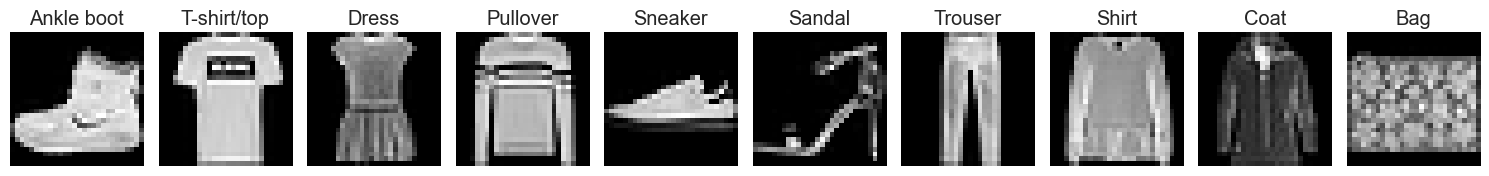

In [4]:
# Create a dictionary to store one example image per class
class_examples = {}

# Iterate through the training dataset
for image, label in cloths_train_data:
    if label not in class_examples:
        class_examples[label] = image
    # Stop if we have one example for each class
    if len(class_examples) == num_classes:
        break

# Plot the example images
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
for idx, (label, image) in enumerate(class_examples.items()):
    axes[idx].imshow(image.squeeze(), cmap="gray")
    axes[idx].set_title(label_names[label])
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

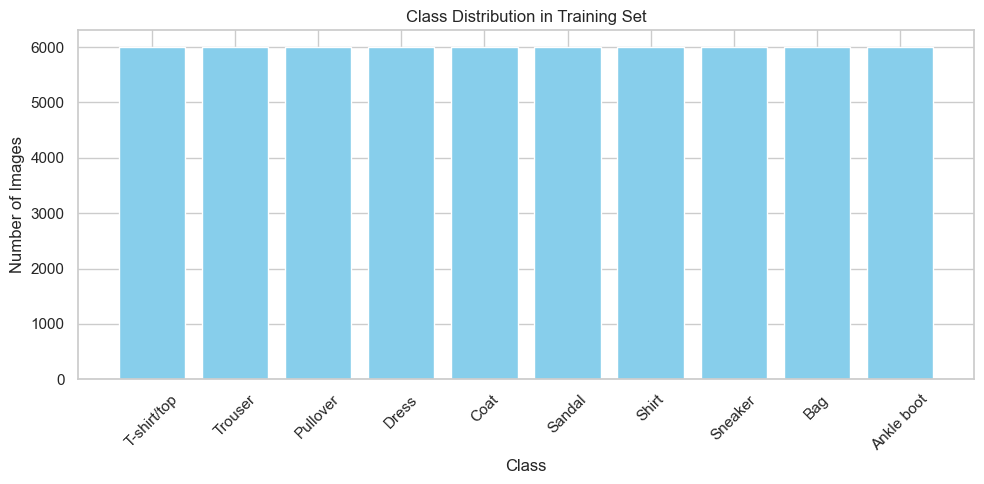

In [5]:
# Count the occurrences of each class label in the training set
class_counts = [0] * num_classes
for _, label in cloths_train_data:
    class_counts[label] += 1

# Plot the class distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.bar(label_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

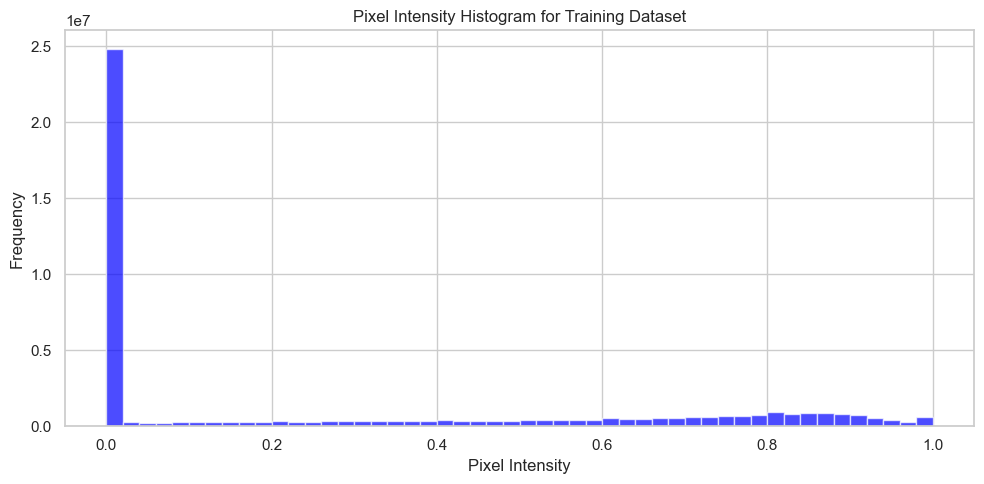

In [6]:
# Flatten all images in the training dataset to calculate pixel intensities
all_pixels = torch.cat([image.view(-1) for image, _ in cloths_train_data])

# Plot the histogram of pixel intensities
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.hist(all_pixels.numpy(), bins=50, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Histogram for Training Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

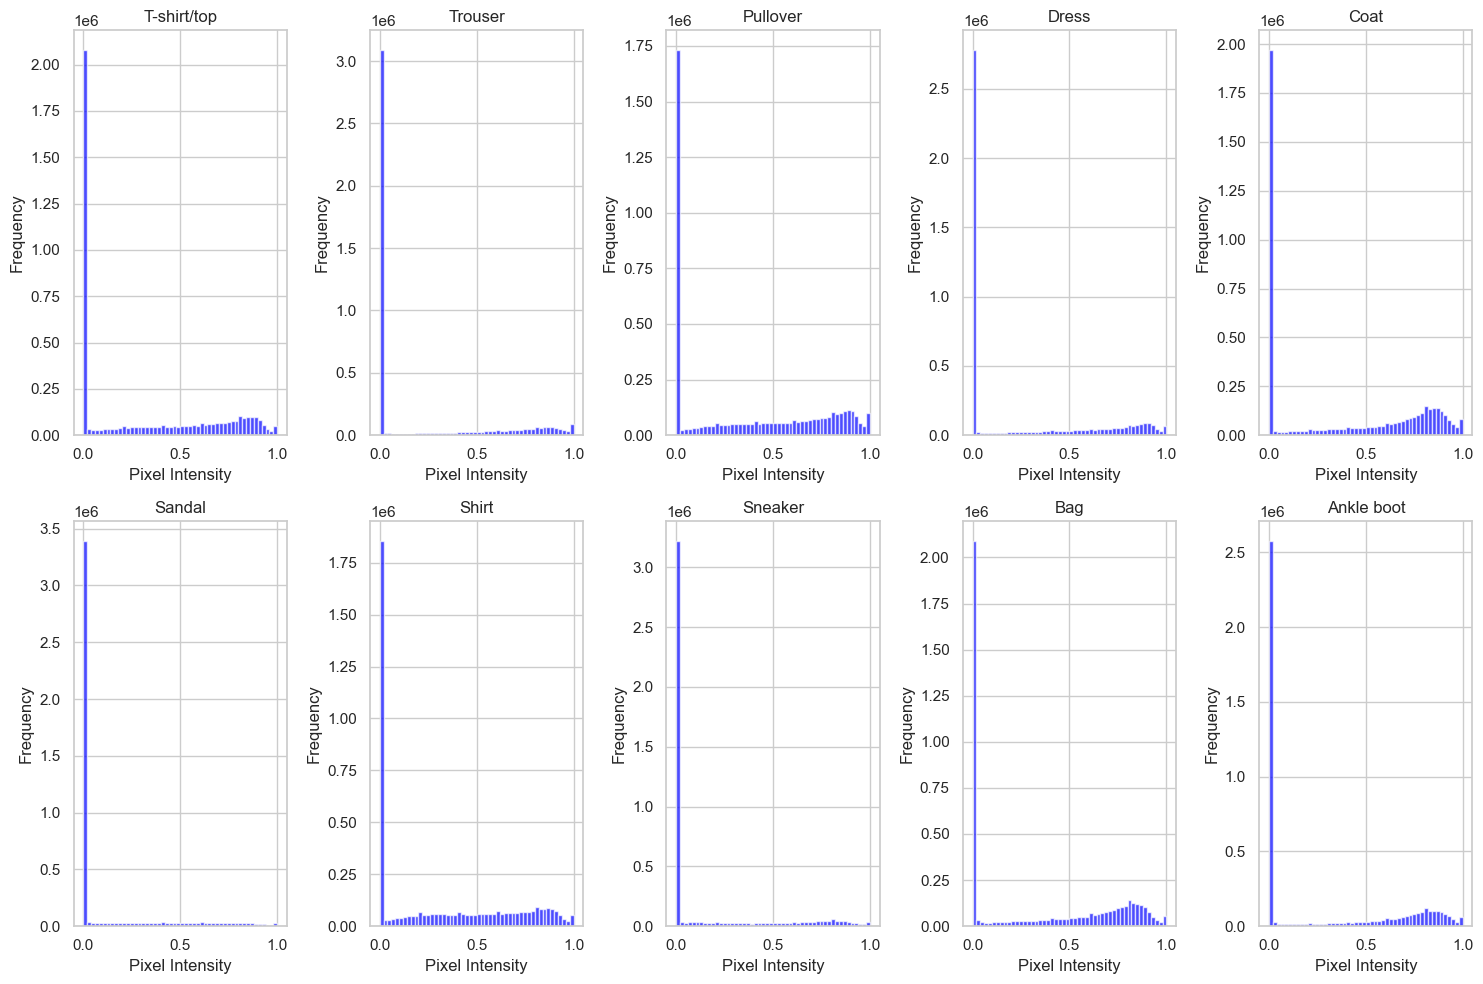

In [7]:
# Step 1: Create a dictionary to hold flattened pixel values per class
class_pixels = defaultdict(list)

# Step 2: Loop through the entire training dataset
for image, label in cloths_train_data:
    flattened = image.view(-1)           # Flatten the image to 1D
    class_pixels[label].append(flattened)

# Step 3: Concatenate pixel values for each class
for label in class_pixels:
    class_pixels[label] = torch.cat(class_pixels[label])  # All pixels for class 'label'

# Step 4: Plot histograms for each class
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()

for label in range(10):
    pixel_values = class_pixels[label].numpy()
    
    ax = axes[label]
    ax.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    ax.set_title(label_names[label])
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

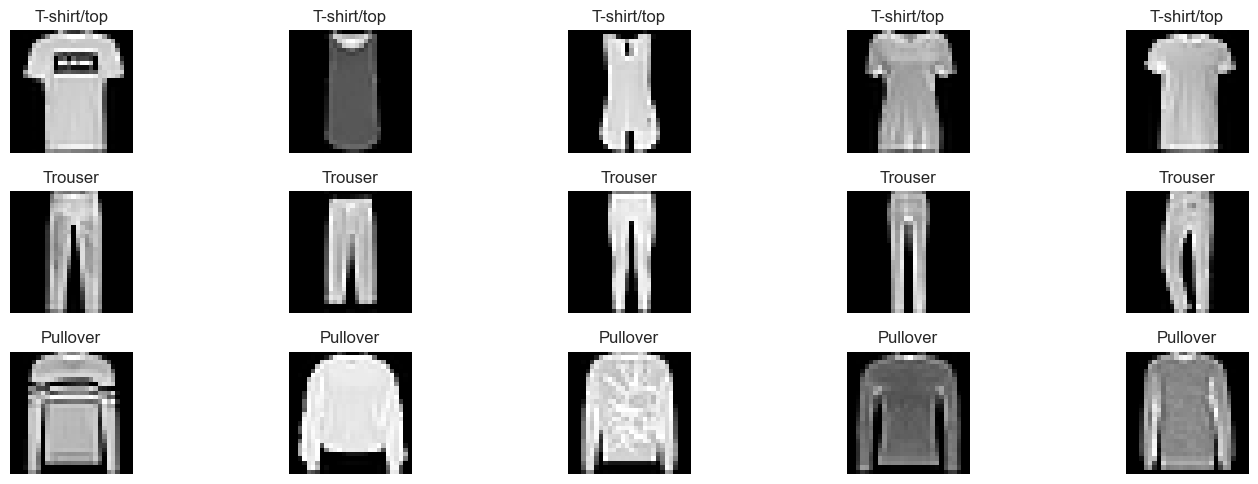

In [8]:
# Select 2–3 classes to display
selected_classes = [0, 1, 2]  # T-shirt/top, Trouser, Pullover

# Number of images to display per class
num_images_per_class = 5

# Create a figure to display the images
sns.set(style="whitegrid")
fig, axes = plt.subplots(len(selected_classes), num_images_per_class, figsize=(15, 5))

for i, class_label in enumerate(selected_classes):
    # Filter images of the selected class
    class_images = list(islice(
    (image for image, label in cloths_train_data if label == class_label),
    5
))
    
    # Display the first few images of the class
    for j in range(num_images_per_class):
        axes[i, j].imshow(class_images[j].squeeze(), cmap="gray")
        axes[i, j].set_title(label_names[class_label])
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Define a transform with random horizontal flip and random rotation
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=10),  # Randomly rotate the image within a range of ±30 degrees
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transform to the training dataset
augmented_cloths_train_data = datasets.FashionMNIST(
    root="Ecommerce_clothing_classifier",
    train=True,
    transform=augmentation_transform,
    download=False  # Set to False since the dataset is already downloaded
)


In [10]:
# Define the sizes for training and validation datasets
train_size = 50000
val_size = 10000

# Split the augmented training data
train_dataset, val_dataset = random_split(augmented_cloths_train_data, [train_size, val_size])

# Create data loaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [11]:
first_train_batch = next(iter(train_loader))
images, labels = first_train_batch
# Check the shape of the images and labels
print(f"Shape of images: {images.shape}")  # Should be (batch_size, channels, height, width)

Shape of images: torch.Size([64, 1, 28, 28])


# Modeling

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) 
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization layer for conv3   
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability

    def forward(self,x):
        x = self.pool(self.elu(self.conv1(x)))
        x = self.pool(self.elu(self.conv2(x)))
        x = self.pool(self.elu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)  # Flatten the tensor
        x = self.elu(self.fc1(x)) # Fully connected layer
        x = self.dropout(x)
        x = self.fc2(x) # Output layer
        return x


In [13]:
model = CNN()  # Initialize the model
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer


In [14]:
model.train()  # Set the model to training mode
num_epochs = 15  # Number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
         

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/15], Loss: 0.5466
Epoch [2/15], Loss: 0.3791
Epoch [3/15], Loss: 0.3404
Epoch [4/15], Loss: 0.3152
Epoch [5/15], Loss: 0.2973
Epoch [6/15], Loss: 0.2827
Epoch [7/15], Loss: 0.2705
Epoch [8/15], Loss: 0.2656
Epoch [9/15], Loss: 0.2557
Epoch [10/15], Loss: 0.2512
Epoch [11/15], Loss: 0.2427
Epoch [12/15], Loss: 0.2339
Epoch [13/15], Loss: 0.2283
Epoch [14/15], Loss: 0.2278
Epoch [15/15], Loss: 0.2213


In [15]:
val_accuracy = Accuracy(task="multiclass", num_classes=10)
val_precision = Precision(task="multiclass", num_classes=10)    
val_recall = Recall(task="multiclass", num_classes=10)
model.eval()  # Set the model to evaluation mode    
val_loss = 0.0  
with torch.no_grad():  # No gradient calculation needed
    for images, labels in val_loader:
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        val_loss += loss.item()

        # Update metrics
        val_accuracy.update(outputs, labels)
        val_precision.update(outputs, labels)
        val_recall.update(outputs, labels)
    val_loss /= len(val_loader)  # Average loss 
    accuracy = val_accuracy.compute()  # Compute accuracy
    precision = val_precision.compute()  # Compute precision
    recall = val_recall.compute()  # Compute recall
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    

Validation Loss: 0.2477, Accuracy: 0.9096, Precision: 0.9096, Recall: 0.9096


In [24]:
# Create a DataLoader for the entire training set
full_train_loader = DataLoader(augmented_cloths_train_data, batch_size=64, shuffle=True)

# Train the model using the entire training set
model = CNN()  # Reinitialize the model
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer
model.train()  # Set the model to training mode
num_epochs = 15  # Number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in full_train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(full_train_loader):.4f}")

Epoch [1/15], Loss: 0.5233
Epoch [2/15], Loss: 0.3667
Epoch [3/15], Loss: 0.3250
Epoch [4/15], Loss: 0.2990
Epoch [5/15], Loss: 0.2845
Epoch [6/15], Loss: 0.2703
Epoch [7/15], Loss: 0.2595
Epoch [8/15], Loss: 0.2511
Epoch [9/15], Loss: 0.2436
Epoch [10/15], Loss: 0.2367
Epoch [11/15], Loss: 0.2326
Epoch [12/15], Loss: 0.2268
Epoch [13/15], Loss: 0.2216
Epoch [14/15], Loss: 0.2166
Epoch [15/15], Loss: 0.2108


In [25]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizer
model.train()  # Set the model to training mode
num_epochs = 5  # Number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in full_train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(full_train_loader):.4f}")

Epoch [1/5], Loss: 0.1805
Epoch [2/5], Loss: 0.1733
Epoch [3/5], Loss: 0.1683
Epoch [4/5], Loss: 0.1677
Epoch [5/5], Loss: 0.1629


In [26]:
# Create a DataLoader for the testing set
test_loader = DataLoader(cloths_test_data, batch_size=64, shuffle=False)

# Initialize metrics for the testing set
test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
test_precision = Precision(task="multiclass", num_classes=num_classes)
test_recall = Recall(task="multiclass", num_classes=num_classes)

# Evaluate the model on the testing set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():  # No gradient calculation needed
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()

        # Update metrics
        test_accuracy.update(outputs, labels)
        test_precision.update(outputs, labels)
        test_recall.update(outputs, labels)

# Compute final metrics
test_loss /= len(test_loader)  # Average loss
accuracy = test_accuracy.compute()  # Compute accuracy
precision = test_precision.compute()  # Compute precision
recall = test_recall.compute()  # Compute recall

# Print the results
print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Test Loss: 0.2048, Accuracy: 0.9311, Precision: 0.9311, Recall: 0.9311


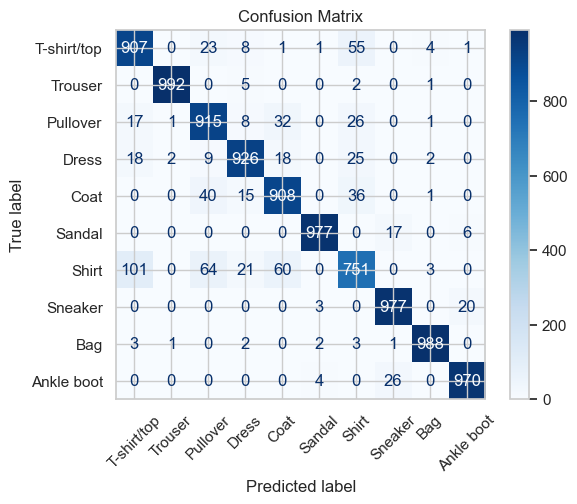

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.91      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.87      0.92      0.89      1000
       Dress       0.94      0.93      0.93      1000
        Coat       0.89      0.91      0.90      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.84      0.75      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Step 1: Collect all predictions and true labels from the test set
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradient calculation needed
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Calculate recall and precision scores for each class
report = classification_report(all_labels, all_preds, target_names=label_names, zero_division=0)
print("Classification Report:\n")
print(report)

In [ ]:
# Save the model's state dictionary
#torch.save(model.state_dict(), "fashion_mnist_cnn.pth")
#print("Model saved as fashion_mnist_cnn.pth")

Model saved as fashion_mnist_cnn.pth
